In [24]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json


In [25]:


def add_hours_dam(df, start_hour, interval=48):
    for i in range(start_hour, start_hour+interval):
        start = str(i)
        df["DAM LMP_PRC_"+start+"_hours_ago"] = 0.0
    for i in range(len(df)-1, interval-1, -1):
        for j in range(start_hour, start_hour+interval):
            start = str(j)
            v = df['DAM LMP_PRC'].iloc[i-j,] 
            df.at[i, "DAM LMP_PRC_"+start+"_hours_ago"] =  v
    return df


def add_hours_rtm(df, start_hour, interval=48):
    for rtm in range(1, 13):
        for i in range(start_hour, start_hour+interval):
            start = str(i)
            df["RTM_"+str(rtm) +"_LMP_PRC_"+start+"_hours_ago"] = 0.0
        for i in range(len(df)-1, interval-1, -1):
            for j in range(start_hour, start_hour+interval):
                start = str(j)
                v = df[('RTM LMP_PRC', rtm)].iloc[i-j,] 
                df.at[i, "RTM_"+str(rtm) +"_LMP_PRC_"+start+"_hours_ago"] =  v
    return df

def add_hours_gap(df, start_hour, interval=48):
    for i in range(start_hour, start_hour+interval):
        start = str(i)
        df["GAP LMP_PRC_"+start+"_hours_ago"] = 0.0
    for i in range(len(df)-1, interval-1, -1):
        for j in range(start_hour, start_hour+interval):
            start = str(j)
            v = df['Gap'].iloc[i-j,] 
            df.at[i, "GAP LMP_PRC_"+start+"_hours_ago"] =  v
    return df

In [26]:
from sklearn.metrics import mean_absolute_error

def MAE(true, predicted):
    return mean_absolute_error(true, predicted)

def r_MAE(true, predicted):
    return mean_absolute_error(true, predicted)/np.mean(true)

def MSE(true, predicted):
    squared_diff = np.square(true - predicted)
    return np.mean(squared_diff)

# Root Mean Square Error
def RMSE(true, predicted):
    squared_diff = np.square(true - predicted)    
    return np.sqrt(np.mean(squared_diff))

# R-squared, coefficient of determination
def R_squared(true, predicted):
    true      = np.array(true)
    predicted = np.array(predicted)
    sum_squared_diff = sum(np.square(true - predicted))
    variance  = sum(np.square(true - np.mean(true)))
    calc_r2   = 1 - (sum_squared_diff / variance)
    return calc_r2

def r_MSE(true, predicted):
    mse = MSE(true, predicted)
    return mse/np.mean(true)

def r_RMSE(true, predicted):
    rmse = RMSE(true, predicted)
    return rmse/np.mean(true)


def MAPE(true, predicted): 
    return np.mean(np.abs((true - predicted) / true)) * 100

In [27]:
def Evaluate_Scaled(Y_true, predictions):
    print('rMAE '+str(r_MAE(Y_true, predictions)*100) +'%')
    print('rRMSE '+str(r_RMSE(Y_true, predictions)*100)+'%')
    print('MAPE '+str(MAPE(Y_true, predictions))+'%')

def Evaluate(Y_true, predictions):
    print('MAE '+str(MAE(Y_true, predictions)))
    print('RMSE '+str(RMSE(Y_true, predictions)))

In [28]:
df = pd.read_pickle('df.pkl')
df = df.reset_index(drop=True)
Y_cols = [('RTM LMP_PRC', 1)] 
X_cols = [col for col in list(df) if col not in Y_cols+[
('HASP LMP_CONG_PRC', 1),
('HASP LMP_CONG_PRC', 2),
('HASP LMP_CONG_PRC', 3),
('HASP LMP_CONG_PRC', 4),
('HASP LMP_ENE_PRC', 1),
('HASP LMP_ENE_PRC', 2),
('HASP LMP_ENE_PRC', 3),
('HASP LMP_ENE_PRC', 4),
('HASP LMP_GHG_PRC', 1),
('HASP LMP_LOSS_PRC', 1),
('HASP LMP_LOSS_PRC', 2),
('HASP LMP_LOSS_PRC', 3),
('HASP LMP_LOSS_PRC', 4),
('HASP LMP_PRC', 1),
('HASP LMP_PRC', 2),
('HASP LMP_PRC', 3),
('HASP LMP_PRC', 4),
('RTM LMP_CONG_PRC', 1),
('RTM LMP_CONG_PRC', 2),
('RTM LMP_CONG_PRC', 3),
('RTM LMP_CONG_PRC', 4),
('RTM LMP_CONG_PRC', 5),
('RTM LMP_CONG_PRC', 6),
('RTM LMP_CONG_PRC', 7),
('RTM LMP_CONG_PRC', 8),
('RTM LMP_CONG_PRC', 9),
('RTM LMP_CONG_PRC', 10),
('RTM LMP_CONG_PRC', 11),
('RTM LMP_CONG_PRC', 12),
('RTM LMP_ENE_PRC', 1),
('RTM LMP_ENE_PRC', 2),
('RTM LMP_ENE_PRC', 3),
('RTM LMP_ENE_PRC', 4),
('RTM LMP_ENE_PRC', 5),
('RTM LMP_ENE_PRC', 6),
('RTM LMP_ENE_PRC', 7),
('RTM LMP_ENE_PRC', 8),
('RTM LMP_ENE_PRC', 9),
('RTM LMP_ENE_PRC', 10),
('RTM LMP_ENE_PRC', 11),
('RTM LMP_ENE_PRC', 12),
('RTM LMP_GHG_PRC', 1),
('RTM LMP_GHG_PRC', 7),
('RTM LMP_LOSS_PRC', 1),
('RTM LMP_LOSS_PRC', 2),
('RTM LMP_LOSS_PRC', 3),
('RTM LMP_LOSS_PRC', 4),
('RTM LMP_LOSS_PRC', 5),
('RTM LMP_LOSS_PRC', 6),
('RTM LMP_LOSS_PRC', 7),
('RTM LMP_LOSS_PRC', 8),
('RTM LMP_LOSS_PRC', 9),
('RTM LMP_LOSS_PRC', 10),
('RTM LMP_LOSS_PRC', 11),
('RTM LMP_LOSS_PRC', 12),
('RTM LMP_PRC', 1),
('RTM LMP_PRC', 2),
('RTM LMP_PRC', 3),
('RTM LMP_PRC', 4),
('RTM LMP_PRC', 5),
('RTM LMP_PRC', 6),
('RTM LMP_PRC', 7),
('RTM LMP_PRC', 8),
('RTM LMP_PRC', 9),
('RTM LMP_PRC', 10),
('RTM LMP_PRC', 11),
('RTM LMP_PRC', 12),
'DAM LMP_CONG_PRC',
'DAM LMP_GHG_PRC',
('HASP LMP_CONG_PRC', 1),
('HASP LMP_CONG_PRC', 2),
('HASP LMP_CONG_PRC', 3),
('HASP LMP_CONG_PRC', 4),
('HASP LMP_ENE_PRC', 1),
('HASP LMP_ENE_PRC', 2),
('HASP LMP_ENE_PRC', 3),
('HASP LMP_ENE_PRC', 4),
('HASP LMP_GHG_PRC', 1),
('HASP LMP_LOSS_PRC', 1),
('HASP LMP_LOSS_PRC', 2),
('HASP LMP_LOSS_PRC', 3),
('HASP LMP_LOSS_PRC', 4),
('HASP LMP_PRC', 1),
('HASP LMP_PRC', 2),
('HASP LMP_PRC', 3),
('HASP LMP_PRC', 4),
('RTM LMP_CONG_PRC', 1),
('RTM LMP_CONG_PRC', 2),
('RTM LMP_CONG_PRC', 3),
('RTM LMP_CONG_PRC', 4),
('RTM LMP_CONG_PRC', 5),
('RTM LMP_CONG_PRC', 6),
('RTM LMP_CONG_PRC', 7),
('RTM LMP_CONG_PRC', 8),
('RTM LMP_CONG_PRC', 9),
('RTM LMP_CONG_PRC', 10),
('RTM LMP_CONG_PRC', 11),
('RTM LMP_CONG_PRC', 12),
('RTM LMP_GHG_PRC', 1),
('RTM LMP_GHG_PRC', 7),
'DAM LMP_ENE_PRC',
'DAM LMP_LOSS_PRC',
'Actual_Demand',
('RTM LMP_PRC', 1),
'DAM LMP_PRC',]]
          
Y = df[Y_cols]
X = df[X_cols]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10615, shuffle=False, random_state=42)

ss1 = MinMaxScaler(feature_range=(0, 1))
X_train = ss1.fit_transform(X_train)
X_test = ss1.transform(X_test)
ss2 = MinMaxScaler(feature_range=(0, 1))
Y_train = ss2.fit_transform(Y_train)
Y_test = ss2.transform(Y_test)

In [80]:
lookback_length = 150   
batch_size = 1

In [81]:
from keras.preprocessing.sequence import TimeseriesGenerator
train_sequences  = TimeseriesGenerator(X_train,
                                       Y_train,
                                       length=lookback_length,
                                       batch_size=batch_size)
test_sequences = TimeseriesGenerator(X_test,
                                     Y_test,
                                     length=lookback_length,
                                     batch_size=batch_size)

In [ ]:
model = Sequential()

model.add(LSTM(units=100, input_shape=(lookback_length, 60)))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit_generator(train_sequences, validation_data=test_sequences, epochs=3, verbose=1)

60

In [67]:
scaled_predictions = model.predict_generator(test_sequences)

In [68]:
Evaluate_Scaled(Y_test[:-lookback_length], scaled_predictions)

rMAE 9.859818089757534%
rRMSE 20.908574240841386%
MAPE 8.88368342477697%


In [63]:
predictions = ss2.inverse_transform(scaled_predictions.reshape(-1, 1))

In [64]:
Y_true = []
temp = ss2.inverse_transform(Y_test)
for item in temp:
    Y_true.append(item[0])

In [65]:
Evaluate(Y_true[:-lookback_length], predictions)

MAE 30.485223677201546
RMSE 66.46030292787826


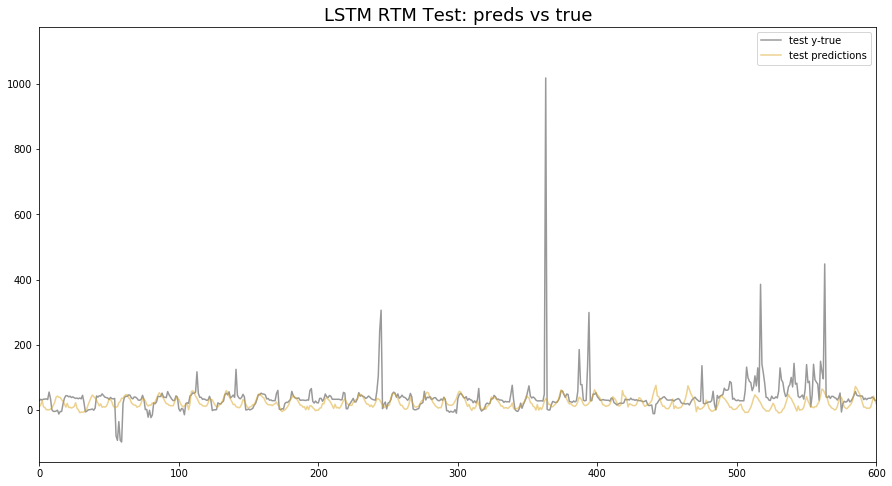

In [66]:

plt.figure(figsize=(15,8))

plt.plot(Y_true,
         label='test y-true',
         alpha = 0.8,
         color='grey')
plt.plot(predictions,
         label='test predictions',
         alpha = 0.5,
         color='goldenrod')
plt.legend()
plt.xlim(0, 600)
plt.title('LSTM RTM Test: preds vs true', fontsize=18)
# plt.savefig('../images/dam_RNN_12_test_pred_vs_true_zoomed.jpg', bbox_inches='tight')
plt.show();